In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import *

In [4]:
#划分训练集和测试集
def split_data(X, Y):
    Y = Y.reshape((54256, 1))
    data = np.hstack((X,Y))
    np.random.shuffle(data)
    data_train = data[0:40692, :]   #75%作为训练集
    data_test = data[40692:54256, :]   #25%作为测试集
    X_train = data_train[:, 0:511].T
    Y_train = data_train[:, 511].reshape((1,40692))
    X_test = data_test[:, 0:511].T
    Y_test = data_test[:, 511].reshape((1,13564))
    return X_train, Y_train, X_test, Y_test

In [5]:
#随机初始化参数
def initialize(layers_dims):
    L = len(layers_dims)
    params = {}
    for l in range(1, L):
        params['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
        params['b' + str(l)] = np.zeros((layers_dims[l], 1))
    
    assert (params['W' + str(l)].shape == (layers_dims[l], layers_dims[l-1]))
    assert (params['b' + str(l)].shape == (layers_dims[l], 1))
    
    return params

In [6]:
#激活函数sigmoid
def sigmoid(Z):
    A = 1./ (1 + np.exp(-Z))
    cache = Z
    return A, cache

In [7]:
#sigmoid反向传播
def sigmoid_backward(dA, cache):
    Z = cache
    A = 1./ (1 + np.exp(-Z))
    dZ = dA * A * (1-A)
    assert (dZ.shape == Z.shape)
    return dZ

In [8]:
#激活函数ReLU
def relu(Z):
    A = np.maximum(0,Z)
    assert (A.shape == Z.shape)
    cache = Z 
    return A, cache

In [9]:
#ReLU反向传播
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0   #当Z值小于0时，导数皆为0
    assert (dZ.shape == Z.shape)
    return dZ

In [10]:
#前向传播线性计算部分
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

In [11]:
#前向传播线性激活部分
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
 
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
 
    return A, cache

In [12]:
#前向传播
def L_model_forward(X, params):
    caches = []
    A = X
    L = len(params) // 2   
    for l in range(1, L):   
        A_prev = A
        A, cache = linear_activation_forward(A_prev, params['W' + str(l)], params['b' + str(l)], "relu")
        caches.append(cache)
 
    AL, cache = linear_activation_forward(A, params['W' + str(L)], params['b' + str(L)], "sigmoid") 
    caches.append(cache)
 
    assert (AL.shape == (1, X.shape[1]))
 
    return AL, caches

In [13]:
#损失函数
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = - np.sum(np.multiply(np.log(AL), Y) + np.multiply(np.log(1 - AL), 1 - Y)) / m
    cost = np.squeeze(cost)
    assert (cost.shape == ()) 
    return cost

In [14]:
#反向传播线性计算部分
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ, A_prev.T) / m
    db = np.sum(dZ, axis=1, keepdims=True) / m
    dA_prev = np.dot(W.T, dZ)
 
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
 
    return dA_prev, dW, db

In [15]:
#反向传播线性激活部分
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
 
    return dA_prev, dW, db

In [16]:
#反向传播
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
 
    current_cache = caches[L - 1]   
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")
 
    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
 
    return grads

In [17]:
#更新参数
def update_parameters(params, grads, learning_rate):
    L = len(params) // 2
    for l in range(L):
        params["W" + str(l + 1)] = params["W" + str(l + 1)] - learning_rate * grads["dW" + str(l + 1)]
        params["b" + str(l + 1)] = params["b" + str(l + 1)] - learning_rate * grads["db" + str(l + 1)]
    return params

In [33]:
#神经网络
def L_layer_NN(X, Y, layers_dims, learning_rate, num_iterations, mini_batch):
    cost_list = []
    params = initialize(layers_dims)   #初始化参数
    m = int(X.shape[1] / mini_batch)   #用mini BGD时每一次用到的训练集中样本数量
    
    #迭代
    for i in range(num_iterations):
        #mini BGD每次使用一部分训练集
        for j in range(mini_batch):
            AL, caches = L_model_forward(X[:, m*j: m*(j+1)], params)   #正向传播           
            grads = L_model_backward(AL, Y[:, m*j: m*(j+1)], caches)   #反向传播
            params = update_parameters(params, grads, learning_rate)   #更新参数
        
        cost = compute_cost(AL, Y[:, m*j: m*(j+1)])   #计算误差
        cost_list = np.append(cost_list, cost)   #将误差存储起来便于画图
        #打印误差
        if (i == 0):
            costs.append(cost)
            print ("最初误差为：%f" % cost)
        if ((i+1) % 100 == 0):
            costs.append(cost)
            print ("经过%i次迭代，误差为：%f" % ((i+1), cost))
    #画图
    iteration = np.arange(0, num_iterations, 1)
    plt.figure(figsize=(4,2.5))
    plt.plot(iteration, cost_list)
    plt.xlabel('number of iterations')
    plt.ylabel('error')  
    plt.show()
 
    return params

神经网络共5层, 各层节点数分别为：
511 20 15 8 1 

学习率：0.001
每次学习用训练集的1/ 12
迭代次数：1000


最初误差为：0.689989
经过100次迭代，误差为：0.517810
经过200次迭代，误差为：0.512901
经过300次迭代，误差为：0.508272
经过400次迭代，误差为：0.504776
经过500次迭代，误差为：0.498708
经过600次迭代，误差为：0.494349
经过700次迭代，误差为：0.504575
经过800次迭代，误差为：0.491927
经过900次迭代，误差为：0.488545
经过1000次迭代，误差为：0.492639


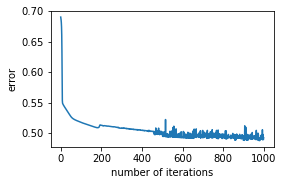

在测试集上的分类正确率为：79.67%
程序运行时间： 298.4998526573181


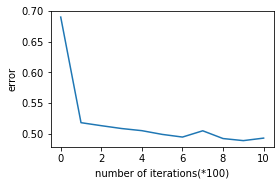

In [37]:
if __name__ == "__main__":
    #导入数据文件
    X = np.loadtxt('features.txt', delimiter=',', skiprows=1, dtype=float)
    Y = np.loadtxt('labels.txt', delimiter=',', skiprows=1, usecols=(1))
    
    X_train, Y_train, X_test, Y_test = split_data(X, Y)   #划分数据集
    
    #一系列参数
    layers_dims = [511, 20, 15, 8, 1]
    num_iterations = 1000
    learning_rate = 0.001
    mini_batch = 12
    
    print(f"神经网络共{len(layers_dims)}层, 各层节点数分别为：")
    for i in layers_dims:
        print(i, end = ' ')
    print("\n")
    print("学习率：%s" % str(learning_rate))
    print("每次学习用训练集的1/", str(mini_batch))
    print("迭代次数：%d" % num_iterations)
    print("\n")

    #训练
    params = L_layer_NN(X_train, Y_train, layers_dims, learning_rate, num_iterations, mini_batch)
    
    #测试
    test_num = X_test.shape[1]
    AL_test, caches_test = L_model_forward(X_test, params)
    AL_test[(AL_test < 0.5) | (AL_test == 0.5)] = 0
    AL_test[AL_test > 0.5] = 1
    correct = 0
    for i in range(test_num):
        if (AL_test[0, i] == Y_test[0, i]):
            correct += 1 
    precision = correct / test_num
    print ("在测试集上的分类正确率为：%.2f%%" % (precision * 100))